In [1]:
import sympy as sym
import numpy as np
#import pylab as pl
from IPython.display import display, Math, Latex
sym.init_printing(use_unicode=True)
import sympy.utilities.autowrap as symauto

epss,Dels,nus,ta,tb,pa,pb,kappa,kappb,kas,kbs =\
sym.symbols('epsilon Delta nus ta tb pa pb kappaa kappab kas kbs',real=True)
kapp1a,kapp1b,Las,Lbs = \
sym.symbols('kappa1a kappa1b Las Lbs',real=True)

#Functions for evaluation
Ema = sym.exp(sym.I*(-nus*ta+pa))
Emb = sym.exp(sym.I*(-nus*tb+pb))
Epa = sym.exp(sym.I*(nus*ta+pa))
Epb = sym.exp(sym.I*(nus*tb+pb))
dma = kappa-sym.I*(nus-Dels) + kas*Epa         #d_{-,a}(\nu)
dmb = kappb-sym.I*(nus+Dels) + kbs*Epb         #d_{-,b}(\nu)
dpa = kappa-sym.I*(nus+Dels) + kas*sym.conjugate(Ema)   #d_{+,a}(\nu)
dpb = kappb-sym.I*(nus-Dels) + kbs*sym.conjugate(Emb)   #d_{+,b}(\nu)
Lab = sym.Abs(epss)**2 - dpa*dmb          #\Lambda_{ab}(\nu)
Lba = sym.Abs(epss)**2 - dpb*dma          #\Lambda_{ba}(\nu)

#Expectation value of the outgoing photon number
nom_ba = (kappa+kas*sym.cos(pa-nus*ta)-kapp1a*Las)*(kappb+kbs*sym.cos(pb+nus*tb))
nom_ab = (kappb+kbs*sym.cos(pb+nus*tb)-kapp1b*Lbs)*(kappa+kas*sym.cos(pa-nus*ta))
term_ba  = 2*epss**2*(sym.diff(nom_ba/(Lab*sym.conjugate(Lab)),pa)-sym.diff(nom_ba/(Lab*sym.conjugate(Lab)),pb))
term_ab  = 2*epss**2*(sym.diff(nom_ab/(Lba*sym.conjugate(Lba)),pa)-sym.diff(nom_ab/(Lba*sym.conjugate(Lba)),pa))
deriv_ba = sym.lambdify((nus,epss,Dels,kappa,kappb,kapp1a,kapp1b,kas,kbs,ta,tb,pa,pb,Las,Lbs), term_ba, modules="numpy")
deriv_ab = sym.lambdify((nus,epss,Dels,kappa,kappb,kapp1a,kapp1b,kas,kbs,ta,tb,pa,pb,Las,Lbs), term_ab, modules="numpy")
#diffp   = sym.Rational(1,2)*(sym.diff(I_pexp,pa)-sym.diff(I_pexp,pb))
#diffm   = sym.Rational(1,2)*(sym.diff(I_mexp,pa)-sym.diff(I_mexp,pb))


In [10]:
sens(0.75,0,10,10,0.5,0.5,1.8833,1.8833,0,0,0,0,nu,nup)

/home/nnem614/Documents/anaconda3/envs/py35/lib/python3.5/site-packages/numpy/ma/core.py:2717: ComplexWarning: Casting complex values to real discards the imaginary part
  order=order, subok=True, ndmin=ndmin)


In [75]:
import numpy as np
#%matplotlib inline
import matplotlib.pyplot as plt
import scipy.integrate as integ
from matplotlib.colors import LogNorm
from IPython.core.debugger import Tracer
#Tracer()() #this one triggers the debugger

def sens(x,delta,kapa,kapb,ra,rb,kta,ktb,phia,phib,La,Lb,nus,nups):
# Function to determine the phase sensitivity of the setup
    import time
    start  = time.clock()

    ## Parameters from inputs ##
    kapa  = kapa*2*np.pi
    kapb  = kapb*2*np.pi
    La    = La/100.
    Lb    = Lb/100.
    phia  = phia*np.pi
    phib  = phib*np.pi
    taua  = kta/kapa
    taub  = ktb/kapa
    Del   = delta*kapa
    eps   = x*kapa
    kap1a = kapa * ra                         #\kappa_{1,a} (coupling on the right hand side in mode a)
    kap1b = kapb * rb                         #\kappa_{1,b} (coupling on the right hand side in mode b)
    kap2a = kapa * (1-ra)                     #\kappa_{2,a} (coupling on the left hand side in mode a)
    kap2b = kapb * (1-rb)                     #\kappa_{2,b} (coupling on the left hand side in mode b)

    ka = 2*np.sqrt(ra*(1-ra)*(1-La))*kapa    #k_a (feedback strength in mode a)
    kb = 2*np.sqrt(rb*(1-rb)*(1-Lb))*kapb    #k_b (feedback strength in mode b)
    
    ### EXPRESSIONS ###
    def Ei(nu,t,phi):
        return np.exp(1j*(nu*t+phi))
    def d(nu,t,phi,kap,Del,k): #dpa if Del&phi, dma if -Del&-phi, dmb if Del&-phi, dpb if -Del&phi
        return kap - 1j*(nu+Del) + k*Ei(nu,t,-phi)
    def Lab(nu):
        return abs(eps)**2 - d(nu,taua,phia,kapa,Del,ka)*d(nu,taub,-phib,kapb,Del,kb)
    def Lba(nu):
        return abs(eps)**2 - d(nu,taub,phib,kapb,-Del,kb)*d(nu,taua,-phia,kapa,-Del,ka)
    def fa(nu,kap1,kap2): #alpha if quantities for a, 1 if kap1=kap1
        return np.sqrt(2*kap1) + np.sqrt(2*kap2*(1-La))*Ei(nu,taua,phia)
    def fb(nu,kap1,kap2): #alpha if quantities for a, 1 if kap1=kap1
        return np.sqrt(2*kap1) + np.sqrt(2*kap2*(1-Lb))*Ei(nu,taub,phib)

    def Da(nu): #Da if p is for b
        return np.sqrt(1-La)*Lba(nu)*Ei(nu,taua,phia) + d(nu,taub,phib,kapb,-Del,kb)*\
    fa(nu,kap1a,kap2a)*fa(nu,kap2a,kap1a)
    def Db(nu): #Da if p is for b
        return np.sqrt(1-Lb)*Lab(nu)*Ei(nu,taub,phib) + d(nu,taua,phia,kapa,Del,ka)*\
    fb(nu,kap1b,kap2b)*fb(nu,kap2b,kap1b)

    def Ea(nu): # Da if p is for b
        return np.sqrt(La)*(np.sqrt(2*kap2a)*d(nu,taub,phib,kapb,-Del,kb)*fa(nu,kap2a,kap1a) + Lba(nu))
    def Eb(nu): # Da if p is for b
        return np.sqrt(Lb)*(np.sqrt(2*kap2b)*d(nu,taua,phia,kapa,Del,ka)*fb(nu,kap2b,kap1b) + Lab(nu))

    def U1ab(nu): # for U1ab p means b
        return np.real(np.abs(fa(-nu,kap2a,kap1a))**2*(np.abs(fb(nu,kap1b,kap2b))**2+2*kap2b*Lb)/np.abs(Lab(nu))**2)
    def V1ba(nup): # for U1ab p means b
        return np.real((np.abs(Da(nup))**2+np.abs(Ea(nup))**2)/np.abs(Lba(nup))**2)
    def U2ab(nu): # for U2ab p means b
        return np.real(np.conjugate(fa(-nu,kap2a,kap1a))*\
    (fb(nu,kap1b,kap2b)*np.conjugate(Db(nu))+np.sqrt(2*kap2b*Lb)*np.conjugate(Eb(nu)))/np.abs(Lab(nu))**2)
    def V2ba(nup): # for U2ab p means b
        return np.real(fb(-nup,kap2b,kap1b)*(np.conjugate(fa(-nup,kap1a,kap2a))*Da(nup)+np.sqrt(2*kap2a*La)*Ea(nup))/\
    np.abs(Lba(nup))**2)
    def U1ba(nu): # for U1ab p means b
        return np.real(np.abs(fb(-nu,kap2b,kap1b))**2*(np.abs(fa(nu,kap1a,kap2a))**2+2*kap2a*La)/np.abs(Lba(nu))**2)
    def V1ab(nup): # for U1ab p means b
        return np.real((np.abs(Db(nup))**2+np.abs(Eb(nup))**2)/np.abs(Lab(nup))**2)
    def U2ba(nu): # for U2ab p means b
        return np.real(np.conjugate(fb(-nu,kap2b,kap1b))*\
    (fa(nu,kap1a,kap2a)*np.conjugate(Da(nu))+np.sqrt(2*kap2a*La)*np.conjugate(Ea(nu)))/np.abs(Lba(nu))**2)
    def V2ab(nup): # for U2ab p means b
        return np.real(fb(-nup,kap2a,kap1a)*(np.conjugate(fb(-nup,kap1b,kap2b))*Db(nup)+np.sqrt(2*kap2b*Lb)*Eb(nup))/\
    np.abs(Lab(nup))**2)
    
    def num1(nu):
        return np.real(np.abs(eps)**2*(np.abs(fa(-nu,kap2a,kap1a))**2/np.abs(Lab(nu))**2*(np.abs(fb(nu,kap1b,kap2b))**2+\
                                                                                          2*kap2b*Lb)))
    def num2(nu):
        return np.real(np.abs(eps)**2*(np.abs(fb(-nu,kap2b,kap1b))**2/np.abs(Lba(nu))**2*(np.abs(fa(nu,kap1a,kap2a))**2+\
                                                                                          2*kap2a*La)))
    
    N=len(nus)
    #nus[int((N-1)/2)]=0
#    plt.figure(1)
#    plt.plot(nus[int((N-1)/2):(N+1)],F1(nus[int((N-1)/2):(N+1)]),label = "F_1")
#    plt.plot(nus[0:int((N+1)/2)],F2(nus[0:int((N+1)/2)]),label = "F_2")
#    plt.xlim(-20,20)
#    plt.plot(nus[0:int((N+1)/2)],F3(nus[0:int((N+1)/2)]),label = "F_3")
#    plt.plot(nus[int((N-1)/2):(N+1)],F4(nus[int((N-1)/2):(N+1)]),label = "F_4")
#    plt.legend()
#    plt.grid(True)
    
    U1ab_int = integ.quad(U1ab,-2000,0)
    V1ba_int = integ.quad(V1ba,0,2000)
    U2ab_int = integ.quad(U2ab,-2000,0)
    V2ba_int = integ.quad(V2ba,0,2000)
    V1ab_int = integ.quad(V1ab,-2000,0)
    U1ba_int = integ.quad(U1ba,0,2000)
    V2ab_int = integ.quad(V2ab,-2000,0)
    U2ba_int = integ.quad(U2ba,0,2000)
    F1 = U1ab_int[0]*V1ba_int[0]-U2ab_int[0]*V2ba_int[0]
    F2 = U1ba_int[0]*V1ab_int[0]-U2ba_int[0]*V2ab_int[0]
    N1_int = integ.quad(num1,-2000,-0.0)
    N2_int = integ.quad(num1,0,2000.0)
#    F1_int = integ.quad(F1,0,np.inf)
#    F2_int = integ.quad(F2,-np.inf,0)
#    F3_int = integ.quad(F3,-np.inf,0)
#    F4_int = integ.quad(F4,0,np.inf)

    def uncert1(nu,nup):
        return 1/np.abs(Lba(nup))**2*(U1ab(nup)+U2ab(nup))*1/np.abs(Lab(nu))**2*(U3ab(nu)+U4ab(nu))
    def uncert2(nu,nup):
        return 1/np.abs(Lab(nup))**2*(U1ba(nup)+U2ba(nup))*1/np.abs(Lba(nu))**2*(U3ba(nu)+U4ba(nu))
       
    nu1,nup1 = np.meshgrid(nus[int((N-1)/2):(N+1)],nups[0:int((N+1)/2)])
    nu2,nup2 = np.meshgrid(nus[0:int((N+1)/2)],nups[int((N-1)/2):(N+1)])

    def N_ba(nu):
        return np.real(deriv_ba(nu,eps,Del,kapa,kapb,kap1a,kap1b,ka,kb,taua,taub,phia,phib,La,Lb))
    def N_ab(nu):
        return np.real(deriv_ab(nu,eps,Del,kapa,kapb,kap1a,kap1b,ka,kb,taua,taub,phia,phib,La,Lb))
#    plt.plot(nu,deriv_ba(2*np.pi*nu,eps,Del,kapa,kapb,kap1a,kap1b,ka,kb,taua,taub,phia,phib,La,Lb))
#    plt.plot(nu,N_ba(2*np.pi*nu))

    Gder_ba = integ.quad(N_ba,0,2000)
    Gder_ab = integ.quad(N_ab,-2000,0)
#    plt.plot(nus,N_ba(nus))
#    plt.figure(2)
#    plt.contourf(nu2,nup2,np.real(uncert1(2*np.pi*nu2,2*np.pi*nup2)),400,cmap=plt.cm.jet,norm = LogNorm())
#    plt.contourf(nu1,nup1,np.real(uncert2(2*np.pi*nu1,2*np.pi*nup1)),400,cmap=plt.cm.jet,norm = LogNorm())
#    plt.colorbar()
 #   plt.figure(2)
 #   plt.contourf(nu,nup,denom(nu,nup),400,cmap=plt.cm.jet,norm = LogNorm())
 #   plt.figure(3)
    return F1+F2, N1_int[0]+N2_int[0], np.real(Gder_ab[0]-Gder_ba[0])**2
nu = np.linspace(-100,100,501)
nup = np.linspace(-100,100,501)

#sens(0.75,0,10,10,0.5,0.5,1.8833,1.8833,0,0.0,1,1,nu,nup)
#sens(0.5,0,10,10,0.933,0.933,0,0,1.,1.,90,90,nu,nup)
#deriv_ba = sym.lambdify((nus,epss,Dels,kappa,kappb,kapp1a,kapp1b,kas,kbs,ta,tb,pa,pb,Las,Lbs), term_ba, modules="numpy")
#deriv_ab = sym.lambdify((nus,epss,Dels,kappa,kappb,kapp1a,kapp1b,kas,kbs,ta,tb,pa,pb,Las,Lbs), term_ab, modules="numpy")
sens(0.01,5,10,10,0,0,0,0,0,0,100,100,nu,nup)


In [64]:
a=4
if a!=4:
    print(a)

In [91]:
import sympy as sym


24536028.576835286

/home/nnem614/Documents/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:43: RuntimeWarning: divide by zero encountered in true_divide
/home/nnem614/Documents/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:45: RuntimeWarning: divide by zero encountered in true_divide


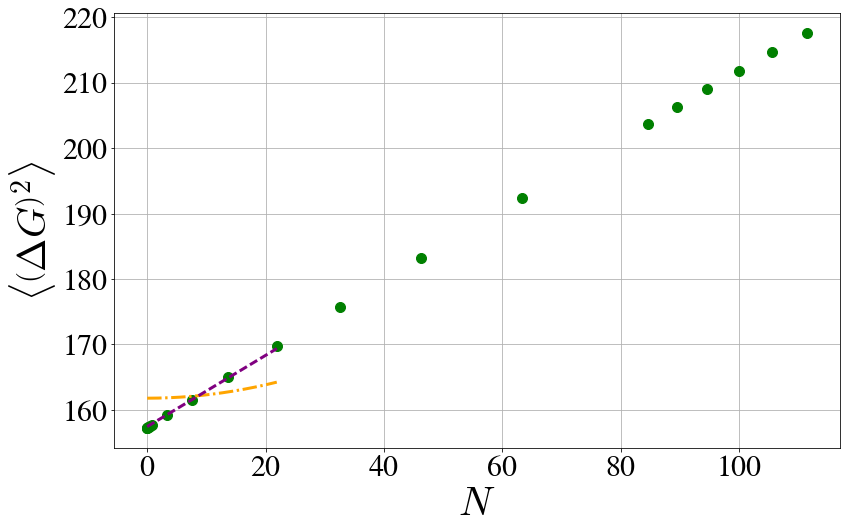

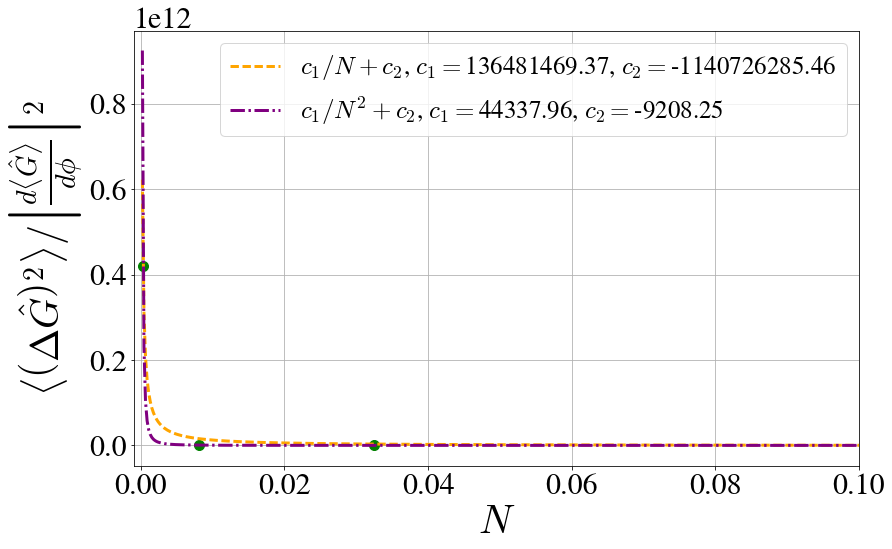

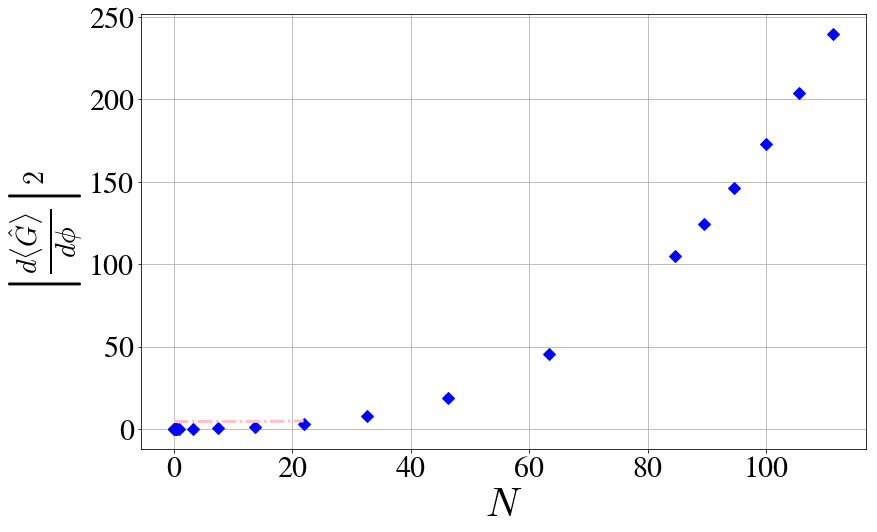

In [123]:
%matplotlib inline
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['mathtext.rm'] = 'serif'
mpl.rc('font',family='FreeSerif')
mpl.rc('xtick',labelsize=30)
mpl.rc('ytick',labelsize=30)

colors={'red':(241/255.,88/255.,84/255.),\
        'orange':(250/255,164/255.,58/255.),\
        'pink':(241/255,124/255.,176/255.),\
        'brown':(178/255,145/255.,47/255.),\
        'purple':(178/255,118/255.,178/255.),\
        'green':(96/255,189/255.,104/255.),\
        'blue':(93/255,165/255.,218/255.),\
        'yellow':(222/255., 207/255., 63/255),\
        'black':(0.,0.,0.)}
fsfont = {'fontname':'FreeSerif'}

#L=np.array([1,2,3,4,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95])
#eps=np.array([0.01,0.02,0.03,0.04,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.60,0.65,0.70,0.71,0.72,0.73,0.74,0.75])
eps=np.array([0.001,0.005,0.01,0.02,0.03,0.04,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.46,0.47,0.48,0.49,0.5])
#eps=np.array([0.01,0.02,0.03,0.04,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.92,0.94,0.96,0.98,0.99])
#F=np.zeros(len(L))
#N=np.zeros(len(L))
#Gder=np.zeros(len(L))
F=np.zeros(len(eps))
N=np.zeros(len(eps))
Gder=np.zeros(len(eps))

nu = np.linspace(-100,100,11)
nup = np.linspace(-100,100,11)

#for i in range(0,len(L)):
for i in range(0,len(eps)):
#F[i],N[i],Gder[i] = sens(0.5,0,10,10,0.933,0.933,0,0,1.,1.0,L[i],L[i],nu,nup)
    #F[i],N[i],Gder[i] = sens(eps[i],0,10,10,0.933,0.933,0,0,1.,1.0,2,2,nu,nup)
    #F[i],N[i],Gder[i] = sens(eps[i],0,10,10,0.01,0.01,0,0,0.,0.0,100,100,nu,nup)
#    F[i],N[i],Gder[i] = sens(0.75,0,10,10,0.5,0.5,1.8833,1.8833,0.,0.0,L[i],L[i],nu,nup)
    F[i],N[i],Gder[i] = sens(eps[i],0,10,10,0.5,0.5,1.8833,1.8833,0.,0.0,50,50,nu,nup)

def func(x,a,c):
    return a*x**2+c
def func2(x,a,c):
    return a*x+c
def func3(x,a,c):
    return a/(x)+c
def func4(x,a,c):
    return a/(x)**2+c
def func6(x,a,c):
    return a/x**3+c
def func5(x,a,c):
    return a*x**4+c

line = np.linspace(0,N[int(len(N)/2)],100000)
popt, pcov = curve_fit(func, N[0:], F[0:])
popt2, pcov2 = curve_fit(func2, N, F)
popt3, pcov3 = curve_fit(func3, N[:], F[:]/Gder[:])
popt4, pcov4 = curve_fit(func4, N[:], F[:]/Gder[:])
#popt6, pcov6 = curve_fit(func6, N[:], F[:]/Gder[:])
popt5, pcov5 = curve_fit(func5, N[:], Gder[:])

plt.figure(1,figsize=(13,8))
plt.plot(N,F,color='green',marker='o',markersize=10,lw=3,ls='')
plt.grid(True)
plt.plot(line,func(line,*popt),color = 'orange',lw=3,ls='dashdot')
plt.plot(line,func2(line,*popt2),color='purple',lw=3,ls='dashed')
#plt.xlim(0,20000)
#plt.ylim(0,1000)
plt.xlabel('$N$',fontsize = 40,**fsfont)
plt.ylabel('$\langle\left(\Delta G\\right)^2\\rangle$',fontsize = 40,**fsfont)
plt.figure(2,figsize=(13,8))
plt.plot(N,F/Gder,color='green',marker='o',markersize=10,lw=2,ls='')
#plt.ylim(-0.01,8)
plt.xlim(-0.001,0.1)
plt.grid(True)
plt.xlabel('$N$',fontsize = 40,**fsfont)
plt.ylabel('$\langle\left(\Delta \hat{G}\\right)^2\\rangle/\left|\\frac{d\langle\hat{G}\\rangle}{d\phi}\\right|^2$',\
           fontsize = 40,**fsfont)
plt.plot(line,func3(line,*popt3),color='orange',lw=3,ls='--',label="$c_1/N+c_2$, $c_1=$%.2f, $c_2=$%.2f" % (popt3[0],popt3[1]))
plt.plot(line,func4(line,*popt4),color='purple',lw=3,ls='-.',label="$c_1/N^2+c_2$, $c_1=$%.2f, $c_2=$%.2f" % (popt4[0],popt4[1]))
#plt.plot(line,func6(line,*popt6),color='yellow',lw=3,ls='-',label="$a/N^3+b$, $a=$%.2f, $b=$%.2f" % (popt6[0],popt6[1]))
plt.legend(fontsize=25)
plt.figure(3,figsize=(13,8))
plt.plot(N,Gder,color='blue',marker='D',markersize=8,lw=2,ls='')
#plt.xlim(-5,200)
plt.grid(True)
plt.xlabel('$N$',fontsize = 40,**fsfont)
plt.ylabel('$\left|\\frac{d\langle\hat{G}\\rangle}{d\phi}\\right|^2$',fontsize = 40,**fsfont)
plt.plot(line,func5(line,*popt5),color='pink',lw=3,ls='-.')

#plt.plot(line,func3(line,*popt3),color='brown',lw=3,ls='--')
#plt.plot(line,func4(line,*popt4),color='pink',lw=3,ls='-.')
#print("pcov3",np.sqrt(np.diag(pcov3)),"\npcov4",np.sqrt(np.diag(pcov4)))